In [1]:

import jax.numpy as jnp
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np
from CNN import *

# I figure out the kernel stuff

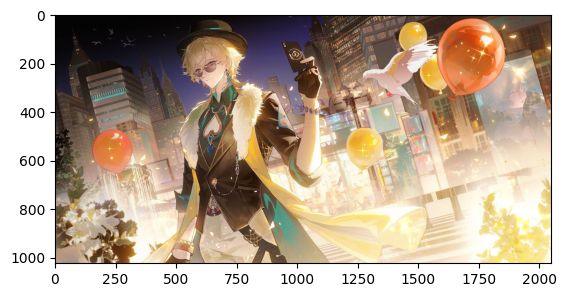

In [3]:
img = Image.open("aventurine.jpeg")
img_arr = np.array(img)
img_arr = img_arr/ 255 #stick it between 0 and 1
plt.imshow(img_arr) # My favorite honkai star rail character as a tester image


In [ ]:
def convolve(img, kernel):
    #img, kernel are both np arrays.
    #Assumes NHWC (batch, height, width, channels)
    #my first attempt of the convolve fxn (this was before I learned einsum)
    if(len(img.shape) == 3):
        img = np.expand_dims(img, 0)
    b, h, w, c = img.shape 
    offset = kernel.shape[0] // 2 
    
    ret_shape = [h - 2 * offset, w - 2 * offset, c]
    
    ret = np.zeros(ret_shape)
    
    for i in range(offset,h- offset): #its over rows first
        for j in range(offset,w- offset):
            ret[i - offset, j - offset] = np.sum(img[0, i - offset: i + offset + 1,j - offset : j + offset + 1,:] * kernel[:,:,None], axis=(0,1))
    return ret    

In [ ]:
sobel_left = np.array([[-1, 0, 1], 
                       [-2, 0, 2],
                       [-1, 0, 1]]).reshape(3,3)

In [ ]:
convolved = convolve(img_arr, sobel_left) #this be slow. LIke very slow. Be patient with it.
#if you want, you can look up sobel kernel results to check that this is what is supposed to happen.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


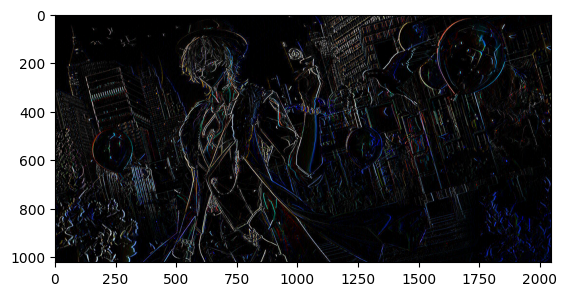

In [ ]:
plt.imshow(convolved) #wow it actually worked.

# Dataset Getting

In [2]:
import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz", )

indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

def batch(x, y, batch_size=64):
    if len(x) % batch_size != 0:
        x = x[:batch_size * (len(x)//batch_size)]
        y=y[:batch_size*(len(x)//batch_size)]
    return np.array(np.split(x, int(len(x) / batch_size), axis=0)), np.split(y, int(len(y)/batch_size), axis=0)

def fix_data(x, y):
    x = x.reshape(x.shape[0], 28*28 )/255
    test = np.zeros((x.shape[0], 10))
    test[np.arange(x.shape[0]),y] = 1
    return (x, test)

fixed_x, fixed_y = fix_data(x_train, y_train)
x_test, y_test = batch(*fix_data(x_test[:1000], y_test[:1000]), 32)
b_x , b_y = batch(fixed_x[:10000], fixed_y[:10000], 64)
b_x = b_x.reshape(b_x.shape[0], b_x.shape[1], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0],  x_test.shape[1], 28, 28, 1)
#this can take a bit (10s)


# A note on Jax's jit
Jax's compilation and model training can take a bit, so this cell will take ~5min to run. It's normal for it to not be printing anything for a bit. You can run them both and then alt tab out, and you'll see the model's accuracies, losses, and outputs if you come back

In [ ]:
kernel_sizes = [5, 3,3]
kernel_filters = [4, 8, 8]
#Kernel sizes is how big the kernels are (height and width) and kernel_filters are how many filters each kernel has.
#So kernel_info=[(5, 4), (3, 8), (3,8)]
#You can put your own list for kernel info.
params = {"kernel_info" : list(zip(kernel_sizes, kernel_filters)), "input_shape": (28, 28, 1), "output_size": 10}

b_y = jnp.array(b_y)
y_test = jnp.array(y_test)

plswork = ConvModel(params)
for i in range(3): #honestly 1 or even 2 are more than enough to train mnist is that simple
    plswork.train_epoch(b_x, b_y,(x_test, y_test), lr=1e-2)
    # plswork.print_layer_info()


Acc: 0.8750 Loss: 1.1065
Acc: 0.9688 Loss: 0.5044
Acc: 0.9688 Loss: 0.4407


# Demo the CNN and have it predict these number

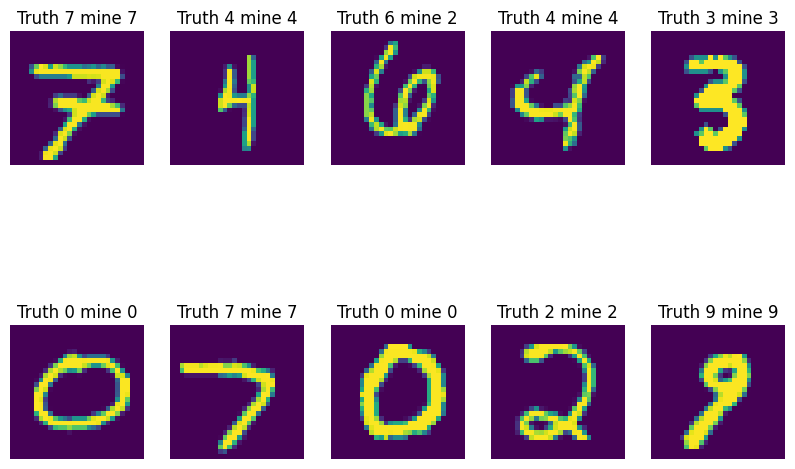

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from CNN import *
%matplotlib inline  

fig = plt.figure(figsize=(10, 7))
pic = 1
for i, img in enumerate(x_test[2][:10]):
  plt.subplot(2, 5, pic)
  plt.axis('off')
  predicted = plswork.fd(jnp.expand_dims(img, 0))
  plt.title(f"Truth {np.argmax(y_test[2][i])} mine {jnp.argmax(predicted)}")
  plt.imshow(img.reshape(28, 28))
  pic+= 1
plt.show()
